In [94]:
import pandas as pd
import plotly.graph_objects as go

In [9]:
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer

In [10]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kaveh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kaveh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kaveh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [11]:
# Use a pipeline as a high-level helper
from transformers import pipeline

In [12]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

# https://github.com/NeelShah18/emot/blob/master/emot/emo_unicode.py  emoticons list
# https://github.com/rishabhverma17/sms_slang_translator/blob/master/slang.txt Chat shortcuts

def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r' ', text)

def remove_punctuations(text):
    punctuations = re.compile(r'[~`!@#$%^&*(,<،>){}\\/|\'"?؟_+-=~\[\]]')
    return punctuations.sub(r' ', text)

def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r' ', text)

def remove_weird_chars(text):
    weridPatterns = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u'\U00010000-\U0010ffff'
                               u"\u200d"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\u3030"
                               u"\ufe0f"
                               u"\u2069"
                               u"\u2066"
                               u"\u200c"
                               u"\u2068"
                               u"\u2067"
                               "]+", flags=re.UNICODE)
    patterns = [re.compile('\r'), re.compile('\n'), re.compile('&amp;')]
    text = weridPatterns.sub(r'', text)
    for p in patterns:
        text = p.sub(r' ', text)
    return text

def remove_extra_repeated_alpha(text):
    """
    Remove extra repeated alphabets in a word
    check these links:
    demo : https://regex101.com/r/ALxocA/1
    Question: https://bit.ly/2DoiPqS
    """
    return re.sub(r'([^\W\d_])\1{2,}', r'\1', text)

In [13]:
def first_step_cleaning(text):
    # text = text.encode('utf-8')
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', str(text)).strip()
    # text = text.replace('-',' ')
    # Remove numbers
    # text = re.sub('\d+', '', text)
    # Case normalization
    text = text.lower()
    # text = p.clean(text).replace("Image","").replace("profile picture","").replace("  ","")
    # Remove URLs, HTML tags, and non-alphanumeric characters
    text = text.replace("\\xc2\\xa9","")
    text = text.replace("\n","")
    text = text.replace("..","")
    text = text.replace("  ","")
    text = text.replace("\x0c","")
    text = text.replace(r"\u0107","")
    for i in range(50):
        text = text.replace("\n{}".format(i),"")
    for i in range(500):
        text = text.replace(r"\u0{}".format(i),"")
    # text = re.sub(r'http\S+', '', single_string)
    # text = re.sub('<[^>]*>', '', text)
    # text = re.sub('[^a-zA-Z0-9]', ' ', text)
    text = remove_urls(text)
    text = remove_html(text)
    text = remove_weird_chars(text)
    text = remove_extra_repeated_alpha(text)
    # Remove punctuations
    # text = "".join([char for char in text if char not in string.punctuation])
    return text

In [14]:
def second_step_cleaning_tokenizing(text):
    # Remove all punctuation except the ones to keep
    translator = str.maketrans('', '', string.punctuation.replace('/', '').replace('-',''))
    text = text.translate(translator)
    # Tokenization
    tokens = word_tokenize(text)

    # Stopword removal
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]

    # Stemming
    stemmer = SnowballStemmer("english")
    stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]

    # Lemmatization
    wnl = WordNetLemmatizer()
    lemmatized_tokens = [wnl.lemmatize(word) for word in stemmed_tokens]

    return lemmatized_tokens

## replace words after ner
> - `apply` works on a row / column basis of a DataFrame
> - `applymap` works element-wise on a DataFrame
> - `map` works element-wise on a Series
> - **Note:** all has been depricated, `map` can be used for all of above

In [8]:
Ner_df = pd.read_excel("must_replace.xlsx")
Ner_df

,original,replace
0,ev,Electrical Vehicle
1,ebikes,Electrical Bike
2,escooters,Electrical Scooters
3,utes,Utility Vehicles
4,evs,Electrical Vehicles
5,phev,Plug-in electrical vehicles
6,oems,Original Equipment Manufactures
7,ipcc,Intergovermental Pannel on Climate Change
8,ato,Australian Taxation Office
9,eu,European Union


In [9]:
check_03 = pd.read_csv("CheckPoint_03_MK_P_01.csv")
check_03

,"12. Do we need different measures to ensure all segments of the road transport sector are able to reduce emissions, and if so what government and industry measures might well support the uptake of electric bikes, micro-mobility and motorbikes?",8. Would vehicle fuel efficiency standards incentivise global manufacturers to send EVs and lower emission vehicles to Australia?,3. What are suitable indicators to measure if we are on track to achieve our goals and objectives?,15. What actions can governments and industry take to strengthen our competitiveness and innovate across the full lifecycle of the EV value chain?,16. How can we expand our existing domestic heavy vehicle manufacturing and assembly capability?,1. Do you agree with the objectives and do you think they will achieve our proposed goals? Are there other objectives we should consider?,6. What information could help increase demand and is Government or industry best placed to inform Australians about EVs?,7. Are vehicle fuel efficiency standards an effective mechanism to reduce passenger and light commercial fleet emissions?,What area best describes where you live?,18. Are there other proposals that could help drive demand for EVs and provide a revenue source to help fund road infrastructure?,...,"10. What design features should the Government consider in more detail for vehicle fuel efficiency standards, including level of ambition, who they should apply to, commencement date, penalties and enforcement?",20. How can we best make sure all Australians get access to the opportunities and benefits from the transition?,Make a general comment,"9. In addition to vehicle fuel efficiency standards for passenger and light commercial vehicles, would vehicle fuel efficiency standards be an appropriate mechanism to increase the supply of heavy vehicle classes to Australia?",Titles,number_of_q_answered,links_crawled_listed,keep_rows_bool,combined_values,cleaned_combined_text
0,"Yes, please.\nPlease follow the Climate Counci...",NaN,Rapidly reduce sales of ICE vehicles\nRapidly ...,NaN,NaN,"I agree with the current objectives, however s...",The Government should be informing Australians...,"Yes, as shown in the EU etc. Please introduce ...",City,NaN,...,"World-best ambition, as soon as possible.","Make riding a bike safe and accessible, as thi...",I took two kids in a pram on a bus to a street...,NaN,#460\nAnonymous,14,https://consult.dcceew.gov.au/national-electri...,True,"Yes, please.Please follow the Climate Council ...","yes, please.please follow the climate council ..."
1,NaN,NaN,NaN,NaN,NaN,NaN,"Government. ""Industry"", (the local distributor...",NaN,City,NaN,...,NaN,NaN,If you want more EVs in Australia allow free t...,NaN,#456\nAnonymous,21,https://consult.dcceew.gov.au/national-electri...,True,"Government. ""Industry"", (the local distributor...","government. industry, (the local distributors ..."
2,Different measures are no doubt needed to supp...,The evidence suggets that they do encourage this.,Setting a target year for banning ICE vehicle ...,Supporting the full lifecyle of battery manufa...,Priotising locally made heavy vehicle and bus ...,"It's unclear whether ""establishing systems and...",Government and industry both have a role to pl...,Indications are that fuel efficiency standards...,City,Fuel excise is not currently utilised for road...,...,Government should consider best practice stand...,Structure incentives appropriately and look at...,Australia is ready for bold and strong commitm...,Fuel efficiency standards would no doubt incre...,#438\nAnonymous,46,https://consult.dcceew.gov.au/national-electri...,True,Different measures are no doubt needed to supp...,different measures are no doubt needed to supp...
3,NaN,Fuel should no longer be relevant in these dis...,"Uptake of EVs, increase of charge station avai...",Support shipping vehicles to the country,NaN,We should not tie ourselves to Australian manu...,A similar body to the AER may be needed to assist,No,

In [10]:
def replace_ner(elem):
    text = str(elem)
    original = Ner_df["original"].tolist()
    replace_el = Ner_df["replace"].tolist()
    for i in range(len(original)):
        text.replace(original[i],replace_el[i])
    return text

In [28]:
first_step_C = check_03.copy()

In [29]:
first_step_C = first_step_C.map(first_step_cleaning)

In [16]:
first_step_C

,"12. Do we need different measures to ensure all segments of the road transport sector are able to reduce emissions, and if so what government and industry measures might well support the uptake of electric bikes, micro-mobility and motorbikes?",8. Would vehicle fuel efficiency standards incentivise global manufacturers to send EVs and lower emission vehicles to Australia?,3. What are suitable indicators to measure if we are on track to achieve our goals and objectives?,15. What actions can governments and industry take to strengthen our competitiveness and innovate across the full lifecycle of the EV value chain?,16. How can we expand our existing domestic heavy vehicle manufacturing and assembly capability?,1. Do you agree with the objectives and do you think they will achieve our proposed goals? Are there other objectives we should consider?,6. What information could help increase demand and is Government or industry best placed to inform Australians about EVs?,7. Are vehicle fuel efficiency standards an effective mechanism to reduce passenger and light commercial fleet emissions?,What area best describes where you live?,18. Are there other proposals that could help drive demand for EVs and provide a revenue source to help fund road infrastructure?,...,"10. What design features should the Government consider in more detail for vehicle fuel efficiency standards, including level of ambition, who they should apply to, commencement date, penalties and enforcement?",20. How can we best make sure all Australians get access to the opportunities and benefits from the transition?,Make a general comment,"9. In addition to vehicle fuel efficiency standards for passenger and light commercial vehicles, would vehicle fuel efficiency standards be an appropriate mechanism to increase the supply of heavy vehicle classes to Australia?",Titles,number_of_q_answered,links_crawled_listed,keep_rows_bool,combined_values,cleaned_combined_text
0,"yes, please. please follow the climate council...",nan,rapidly reduce sales of ice vehicles rapidly l...,nan,nan,"i agree with the current objectives, however s...",the government should be informing australians...,"yes, as shown in the eu etc. please introduce ...",city,nan,...,"world-best ambition, as soon as possible.","make riding a bike safe and accessible, as thi...",i took two kids in a pram on a bus to a street...,nan,#460 anonymous,14,,true,"yes, please.please follow the climate council ...","yes, please.please follow the climate council ..."
1,nan,nan,nan,nan,nan,nan,"government. ""industry"", (the local distributor...",nan,city,nan,...,nan,nan,if you want more evs in australia allow free t...,nan,#456 anonymous,21,,true,"government. ""industry"", (the local distributor...","government. industry, (the local distributors ..."
2,different measures are no doubt needed to supp...,the evidence suggets that they do encourage this.,setting a target year for banning ice vehicle ...,supporting the full lifecyle of battery manufa...,priotising locally made heavy vehicle and bus ...,"it's unclear whether ""establishing systems and...",government and industry both have a role to pl...,indications are that fuel efficiency standards...,city,fuel excise is not currently utilised for road...,...,government should consider best practice stand...,structure incentives appropriately and look at...,australia is ready for bold and strong commitm...,fuel efficiency standards would no doubt incre...,#438 anonymous,46,,true,different measures are no doubt needed to supp...,different measures are no doubt needed to supp...
3,nan,fuel should no longer be relevant in these dis...,"uptake of evs, increase of charge station avai...",support shipping vehicles to the country,nan,we should not tie ourselves to australian manu...,a similar body to the aer may be needed to assist,no,city,nan,...,nan,nan,people in high density housing have no chance ...,nan,#432 anonymous,59,,true,fuel should no longer be relevant in these dis...,f

In [34]:
first_step_C_NER = first_step_C.copy().map(replace_ner)

In [35]:
check_03.iloc[0,0]

'Yes, please.\nPlease follow the Climate Council policy for Sustainable Transport (noting this is aimed at the states and territories): https://www.climatecouncil.org.au/sustainable-transport-policies-states/\nReallocate funding from highways and motorways to active and public transport.\nFund safe, separated bike lane networks so people on electric bikes and scooters are not a danger to people walking.\nIf possible, encourage the States and Territories to roll out enforced 30 km/h zones around schools, playgrounds, high streets, and other places where people want to walk or ride bikes.\nHelp Australians live healthier lives by making walking, riding a bike, and taking the bus or train an easy and safe way to get around.'

In [36]:
first_step_C.iloc[0,0]

'yes, please. please follow the climate council policy for sustainable transport (noting this is aimed at the states and territories):   reallocate funding from highways and motorways to active and public transport. fund safe, separated bike lane networks so people on electric bikes and scooters are not a danger to people walking. if possible, encourage the states and territories to roll out enforced 30 km/h zones around schools, playgrounds, high streets, and other places where people want to walk or ride bikes. help australians live healthier lives by making walking, riding a bike, and taking the bus or train an easy and safe way to get around.'

In [37]:
first_step_C_NER.iloc[0,0]

'yes, please. please follow the climate council policy for sustainable transport (noting this is aimed at the states and territories):   reallocate funding from highways and motorways to active and public transport. fund safe, separated bike lane networks so people on electric bikes and scooters are not a danger to people walking. if possible, encourage the states and territories to roll out enforced 30 km/h zones around schools, playgrounds, high streets, and other places where people want to walk or ride bikes. help australians live healthier lives by making walking, riding a bike, and taking the bus or train an easy and safe way to get around.'

In [38]:
first_step_C_NER.to_csv("CheckPoint_phase_2_W2V_01.csv",index=False)

# CheckPoint_phase_2_W2V_01
### Sentiment Phase

In [8]:
check_w2v_01 = pd.read_csv("CheckPoint_phase_2_W2V_01.csv")
check_w2v_01

,"12. Do we need different measures to ensure all segments of the road transport sector are able to reduce emissions, and if so what government and industry measures might well support the uptake of electric bikes, micro-mobility and motorbikes?",8. Would vehicle fuel efficiency standards incentivise global manufacturers to send EVs and lower emission vehicles to Australia?,3. What are suitable indicators to measure if we are on track to achieve our goals and objectives?,15. What actions can governments and industry take to strengthen our competitiveness and innovate across the full lifecycle of the EV value chain?,16. How can we expand our existing domestic heavy vehicle manufacturing and assembly capability?,1. Do you agree with the objectives and do you think they will achieve our proposed goals? Are there other objectives we should consider?,6. What information could help increase demand and is Government or industry best placed to inform Australians about EVs?,7. Are vehicle fuel efficiency standards an effective mechanism to reduce passenger and light commercial fleet emissions?,What area best describes where you live?,18. Are there other proposals that could help drive demand for EVs and provide a revenue source to help fund road infrastructure?,...,"10. What design features should the Government consider in more detail for vehicle fuel efficiency standards, including level of ambition, who they should apply to, commencement date, penalties and enforcement?",20. How can we best make sure all Australians get access to the opportunities and benefits from the transition?,Make a general comment,"9. In addition to vehicle fuel efficiency standards for passenger and light commercial vehicles, would vehicle fuel efficiency standards be an appropriate mechanism to increase the supply of heavy vehicle classes to Australia?",Titles,number_of_q_answered,links_crawled_listed,keep_rows_bool,combined_values,cleaned_combined_text
0,"yes, please. please follow the climate council...",NaN,rapidly reduce sales of ice vehicles rapidly l...,NaN,NaN,"i agree with the current objectives, however s...",the government should be informing australians...,"yes, as shown in the eu etc. please introduce ...",city,NaN,...,"world-best ambition, as soon as possible.","make riding a bike safe and accessible, as thi...",i took two kids in a pram on a bus to a street...,NaN,#460 anonymous,14,,True,"yes, please.please follow the climate council ...","yes, please.please follow the climate council ..."
1,NaN,NaN,NaN,NaN,NaN,NaN,"government. ""industry"", (the local distributor...",NaN,city,NaN,...,NaN,NaN,if you want more evs in australia allow free t...,NaN,#456 anonymous,21,,True,"government. ""industry"", (the local distributor...","government. industry, (the local distributors ..."
2,different measures are no doubt needed to supp...,the evidence suggets that they do encourage this.,setting a target year for banning ice vehicle ...,supporting the full lifecyle of battery manufa...,priotising locally made heavy vehicle and bus ...,"it's unclear whether ""establishing systems and...",government and industry both have a role to pl...,indications are that fuel efficiency standards...,city,fuel excise is not currently utilised for road...,...,government should consider best practice stand...,structure incentives appropriately and look at...,australia is ready for bold and strong commitm...,fuel efficiency standards would no doubt incre...,#438 anonymous,46,,True,different measures are no doubt needed to supp...,different measures are no doubt needed to supp...
3,NaN,fuel should no longer be relevant in these dis...,"uptake of evs, increase of charge station avai...",support shipping vehicles to the country,NaN,we should not tie ourselves to australian manu...,a similar body to the aer may be needed to assist,no,city,NaN,...,NaN,NaN,people in high density housing have no chance ...,NaN,#432 anonymous,59,,True,fuel should no longer be relevant in these dis...,f

In [9]:
filt_cols = check_w2v_01.copy().iloc[:,:-6]
filt_cols

,"12. Do we need different measures to ensure all segments of the road transport sector are able to reduce emissions, and if so what government and industry measures might well support the uptake of electric bikes, micro-mobility and motorbikes?",8. Would vehicle fuel efficiency standards incentivise global manufacturers to send EVs and lower emission vehicles to Australia?,3. What are suitable indicators to measure if we are on track to achieve our goals and objectives?,15. What actions can governments and industry take to strengthen our competitiveness and innovate across the full lifecycle of the EV value chain?,16. How can we expand our existing domestic heavy vehicle manufacturing and assembly capability?,1. Do you agree with the objectives and do you think they will achieve our proposed goals? Are there other objectives we should consider?,6. What information could help increase demand and is Government or industry best placed to inform Australians about EVs?,7. Are vehicle fuel efficiency standards an effective mechanism to reduce passenger and light commercial fleet emissions?,What area best describes where you live?,18. Are there other proposals that could help drive demand for EVs and provide a revenue source to help fund road infrastructure?,...,13. How could we best increase the number of affordable second hand EVs?,4. Are there other measures by governments and industry that could increase affordability and accessibility of EVs to help drive demand?,19. What more needs to be done nationally to ensure we deliver a nationally comprehensive framework for EVs?,What state or territory do you live in?,5. Over what timeframe should we be incentivising low emission vehicles as we transition to zero emission vehicles?,17. Is it viable to extend Australian domestic manufacturing and assembly capability to other vehicle classes?,"10. What design features should the Government consider in more detail for vehicle fuel efficiency standards, including level of ambition, who they should apply to, commencement date, penalties and enforcement?",20. How can we best make sure all Australians get access to the opportunities and benefits from the transition?,Make a general comment,"9. In addition to vehicle fuel efficiency standards for passenger and light commercial vehicles, would vehicle fuel efficiency standards be an appropriate mechanism to increase the supply of heavy vehicle classes to Australia?"
0,"yes, please. please follow the climate council...",NaN,rapidly reduce sales of ice vehicles rapidly l...,NaN,NaN,"i agree with the current objectives, however s...",the government should be informing australians...,"yes, as shown in the eu etc. please introduce ...",city,NaN,...,NaN,the government should not be trying to sell th...,create a national strategy for near zero emiss...,new south wales,please do not incentivise hybrids or plug-in h...,NaN,"world-best ambition, as soon as possible.","make riding a bike safe and accessible, as thi...",i took two kids in a pram on a bus to a street...,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,"government. ""industry"", (the local distributor...",NaN,city,NaN,...,allow people to freely import them instead of ...,"yes, one of the greatest obstacles to affordab...",NaN,new south wales,NaN,NaN,NaN,NaN,if you want more evs in australia allow free t...,NaN
2,different measures are no doubt needed to supp...,the evidence suggets that they do encourage this.,setting a target year for banning ice vehicle ...,supporting the full lifecyle of battery manufa...,priotising locally made heavy vehicle and bus ...,"it's unclear whether ""establishing systems and...",government and industry both have a role to pl...,indications are that fuel efficiency standards...,city,fuel excise is not currently utilised for road...,...,mandating purchasing of evs for all government...,as per other international jurisdictions such ...,absolutely new builds should be required to in...,new south wales,"only bevs should be incentivised,

In [10]:
pipe = pipeline("text-classification", model="cardiffnlp/twitter-roberta-base-sentiment-latest")
print(pipe)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
pipe("I am a happy man")[0]["label"]

'positive'

In [13]:
def replace_elem_with_sent(elem):
    try:
        if len(str(elem))>10:
            sent = pipe(elem)[0]["label"]
            # print(sent)
            return sent
        else:
            return None
    except:
        return "error"

In [14]:
sent_df = filt_cols.map(replace_elem_with_sent)

In [15]:
sent_df

,"12. Do we need different measures to ensure all segments of the road transport sector are able to reduce emissions, and if so what government and industry measures might well support the uptake of electric bikes, micro-mobility and motorbikes?",8. Would vehicle fuel efficiency standards incentivise global manufacturers to send EVs and lower emission vehicles to Australia?,3. What are suitable indicators to measure if we are on track to achieve our goals and objectives?,15. What actions can governments and industry take to strengthen our competitiveness and innovate across the full lifecycle of the EV value chain?,16. How can we expand our existing domestic heavy vehicle manufacturing and assembly capability?,1. Do you agree with the objectives and do you think they will achieve our proposed goals? Are there other objectives we should consider?,6. What information could help increase demand and is Government or industry best placed to inform Australians about EVs?,7. Are vehicle fuel efficiency standards an effective mechanism to reduce passenger and light commercial fleet emissions?,What area best describes where you live?,18. Are there other proposals that could help drive demand for EVs and provide a revenue source to help fund road infrastructure?,...,13. How could we best increase the number of affordable second hand EVs?,4. Are there other measures by governments and industry that could increase affordability and accessibility of EVs to help drive demand?,19. What more needs to be done nationally to ensure we deliver a nationally comprehensive framework for EVs?,What state or territory do you live in?,5. Over what timeframe should we be incentivising low emission vehicles as we transition to zero emission vehicles?,17. Is it viable to extend Australian domestic manufacturing and assembly capability to other vehicle classes?,"10. What design features should the Government consider in more detail for vehicle fuel efficiency standards, including level of ambition, who they should apply to, commencement date, penalties and enforcement?",20. How can we best make sure all Australians get access to the opportunities and benefits from the transition?,Make a general comment,"9. In addition to vehicle fuel efficiency standards for passenger and light commercial vehicles, would vehicle fuel efficiency standards be an appropriate mechanism to increase the supply of heavy vehicle classes to Australia?"
0,neutral,None,neutral,None,None,neutral,neutral,neutral,None,None,...,None,negative,neutral,neutral,negative,None,positive,positive,neutral,None
1,None,None,None,None,None,None,negative,None,None,None,...,neutral,negative,None,neutral,None,None,None,None,neutral,None
2,neutral,negative,neutral,positive,positive,neutral,positive,neutral,None,neutral,...,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,positive,positive
3,None,negative,neutral,neutral,None,negative,neutral,None,None,None,...,neutral,neutral,None,None,neutral,None,None,None,negative,None
4,None,neutral,neutral,neutral,None,neutral,neutral,positive,None,neutral,...,neutral,neutral,neutral,neutral,neutral,None,neutral,None,positive,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,None,neutral,...,neutral,neutral,neutral,None,neutral,neutral,neutral,neutral,None,neutral
237,None,None,neutral,None,None,neutral,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
238,neutral,None,neutral,None,None,positive,neutral,None,None,neutral,...,neutral,negative,None,neutral,neutral,None,None,None,positive,None
239,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,None,neutral,...,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,None,neutral


In [17]:
sent_df.to_csv("mk_sentiment_Proj_01.csv",index=False)

# END of Sentiment project 01 mohammad karimadini
### Start of sent visualization

In [53]:
df = pd.read_csv("mk_sentiment_Proj_01.csv")
df

,"12. Do we need different measures to ensure all segments of the road transport sector are able to reduce emissions, and if so what government and industry measures might well support the uptake of electric bikes, micro-mobility and motorbikes?",8. Would vehicle fuel efficiency standards incentivise global manufacturers to send EVs and lower emission vehicles to Australia?,3. What are suitable indicators to measure if we are on track to achieve our goals and objectives?,15. What actions can governments and industry take to strengthen our competitiveness and innovate across the full lifecycle of the EV value chain?,16. How can we expand our existing domestic heavy vehicle manufacturing and assembly capability?,1. Do you agree with the objectives and do you think they will achieve our proposed goals? Are there other objectives we should consider?,6. What information could help increase demand and is Government or industry best placed to inform Australians about EVs?,7. Are vehicle fuel efficiency standards an effective mechanism to reduce passenger and light commercial fleet emissions?,What area best describes where you live?,18. Are there other proposals that could help drive demand for EVs and provide a revenue source to help fund road infrastructure?,...,13. How could we best increase the number of affordable second hand EVs?,4. Are there other measures by governments and industry that could increase affordability and accessibility of EVs to help drive demand?,19. What more needs to be done nationally to ensure we deliver a nationally comprehensive framework for EVs?,What state or territory do you live in?,5. Over what timeframe should we be incentivising low emission vehicles as we transition to zero emission vehicles?,17. Is it viable to extend Australian domestic manufacturing and assembly capability to other vehicle classes?,"10. What design features should the Government consider in more detail for vehicle fuel efficiency standards, including level of ambition, who they should apply to, commencement date, penalties and enforcement?",20. How can we best make sure all Australians get access to the opportunities and benefits from the transition?,Make a general comment,"9. In addition to vehicle fuel efficiency standards for passenger and light commercial vehicles, would vehicle fuel efficiency standards be an appropriate mechanism to increase the supply of heavy vehicle classes to Australia?"
0,neutral,NaN,neutral,NaN,NaN,neutral,neutral,neutral,NaN,NaN,...,NaN,negative,neutral,neutral,negative,NaN,positive,positive,neutral,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,negative,NaN,NaN,NaN,...,neutral,negative,NaN,neutral,NaN,NaN,NaN,NaN,neutral,NaN
2,neutral,negative,neutral,positive,positive,neutral,positive,neutral,NaN,neutral,...,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,positive,positive
3,NaN,negative,neutral,neutral,NaN,negative,neutral,NaN,NaN,NaN,...,neutral,neutral,NaN,NaN,neutral,NaN,NaN,NaN,negative,NaN
4,NaN,neutral,neutral,neutral,NaN,neutral,neutral,positive,NaN,neutral,...,neutral,neutral,neutral,neutral,neutral,NaN,neutral,NaN,positive,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,NaN,neutral,...,neutral,neutral,neutral,NaN,neutral,neutral,neutral,neutral,NaN,neutral
237,NaN,NaN,neutral,NaN,NaN,neutral,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
238,neutral,NaN,neutral,NaN,NaN,positive,neutral,NaN,NaN,neutral,...,neutral,negative,NaN,neutral,neutral,NaN,NaN,NaN,positive,NaN
239,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,NaN,neutral,...,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,NaN,neutral


In [56]:
# Get value counts for all columns
value_counts_all = df.apply(pd.Series.value_counts).iloc[1:,:].dropna(axis=1).T.reset_index(names="questions")
value_counts_all

,questions,negative,neutral,positive
0,12. Do we need different measures to ensure al...,22.0,120.0,15.0
1,8. Would vehicle fuel efficiency standards inc...,23.0,103.0,13.0
2,3. What are suitable indicators to measure if ...,9.0,186.0,12.0
3,15. What actions can governments and industry ...,16.0,118.0,30.0
4,16. How can we expand our existing domestic he...,13.0,98.0,18.0
5,1. Do you agree with the objectives and do you...,34.0,123.0,46.0
6,6. What information could help increase demand...,32.0,161.0,21.0
7,7. Are vehicle fuel efficiency standards an ef...,32.0,87.0,26.0
8,18. Are there other proposals that could help ...,36.0,117.0,9.0
9,14. Should the Government consider ways to inc...,36.0,95.0,12.0


In [57]:
value_counts_all.to_csv("mk_sentiment_questions_count.csv",index=False)

# Formated sent df checkpoint

In [58]:
formated_sent_df = pd.read_csv("mk_sentiment_questions_count.csv")
formated_sent_df

,questions,negative,neutral,positive
0,12. Do we need different measures to ensure al...,22.0,120.0,15.0
1,8. Would vehicle fuel efficiency standards inc...,23.0,103.0,13.0
2,3. What are suitable indicators to measure if ...,9.0,186.0,12.0
3,15. What actions can governments and industry ...,16.0,118.0,30.0
4,16. How can we expand our existing domestic he...,13.0,98.0,18.0
5,1. Do you agree with the objectives and do you...,34.0,123.0,46.0
6,6. What information could help increase demand...,32.0,161.0,21.0
7,7. Are vehicle fuel efficiency standards an ef...,32.0,87.0,26.0
8,18. Are there other proposals that could help ...,36.0,117.0,9.0
9,14. Should the Government consider ways to inc...,36.0,95.0,12.0


In [60]:
formated_sent_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   questions  21 non-null     object 
 1   negative   21 non-null     float64
 2   neutral    21 non-null     float64
 3   positive   21 non-null     float64
dtypes: float64(3), object(1)
memory usage: 804.0+ bytes


In [62]:
col_names = formated_sent_df.columns.tolist()
col_names

['questions', 'negative', 'neutral', 'positive']

In [87]:
formated_sent_df[col_names[0]] = formated_sent_df[col_names[0]].map(lambda x: x[:3].strip().replace(".","") if x[0].isdigit() else x)
formated_sent_df

,questions,negative,neutral,positive
0,12,22.0,120.0,15.0
1,8,23.0,103.0,13.0
2,3,9.0,186.0,12.0
3,15,16.0,118.0,30.0
4,16,13.0,98.0,18.0
5,1,34.0,123.0,46.0
6,6,32.0,161.0,21.0
7,7,32.0,87.0,26.0
8,18,36.0,117.0,9.0
9,14,36.0,95.0,12.0


In [97]:
formated_sent_df.index.tolist()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

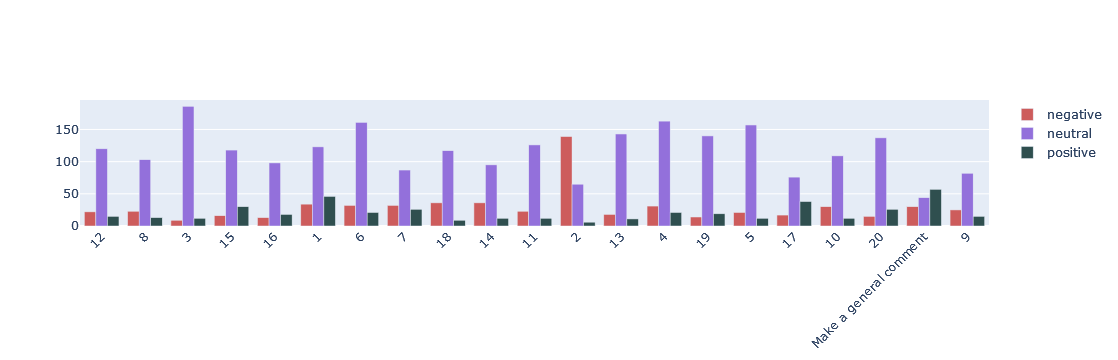

In [93]:
questions = formated_sent_df[col_names[0]].tolist()

fig = go.Figure()
fig.add_trace(go.Bar(
    x=questions,
    y=formated_sent_df[col_names[1]].tolist(),
    name=col_names[1],
    marker_color='indianred'
))
fig.add_trace(go.Bar(
    x=questions,
    y=formated_sent_df[col_names[2]].tolist(),
    name=col_names[2],
    marker_color='MediumPurple'
))
fig.add_trace(go.Bar(
    x=questions,
    y=formated_sent_df[col_names[3]].tolist(),
    name=col_names[3],
    marker_color='DarkSlateGrey'
))

# Here we modify the tickangle of the xaxis, resulting in rotated labels.
fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.show()